This notebook walks through a small case study of Internet path asymmetry using M-Lab's NDT tests, forward traceroutes, and reverse traceroutes.

# Step 0: Setup

In [80]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.distance import great_circle
from google.colab import auth

auth.authenticate_user()
project_id = "measurement-lab"
client = bigquery.Client(project=project_id)

# Step 1: Pick a day and fetch candidate tests
We start by retrieving all NDT tests from a chosen day that include both forward and reverse traceroutes. From these, we focus only on the subset of reverse traceroutes we consider trustworthy---those that reach the destination without relying on assumptions of interdomain path symmetry. As part of this step, we also map IP addresses to ASes using longest-prefix matching and enrich the data with geolocation details from IPInfo. (For a deeper dive into how we filter these cases and what each entry in the RevTr output means, see the companion [blogpost](https://https://docs.google.com/document/d/1j_gKwloSb1bA4ru9UVq0vF3iHrx7UhYldfI5jmU4GwQ/edit?tab=t.vdjq6qknik7a#heading=h.95unxkskf0xb).)

In [2]:
sql_rev = f"""
WITH PerTest AS (
  SELECT
    clientIPVersion,
    clientCity,
    clientASN,
    serverPoP,
    packetLoss.lossRatio AS loss_ratio,
    (SELECT AVG(x) FROM UNNEST(latencyMs) AS x) AS avg_latency,
    (SELECT AVG(x) FROM UNNEST(download.bps) AS x) AS avg_download_bps,
    (SELECT AVG(x) FROM UNNEST(upload.bps) AS x) AS avg_upload_bps
  FROM
    `measurement-lab.cloudflare.speedtest_speed1`
  WHERE
    DATE(date) >= '2025-10-01'
),

-- Compute counts per IP version
CountsPerGroup AS (
  SELECT
    clientCity,
    clientASN,
    serverPoP,
    clientIPVersion,
    COUNT(*) AS num_tests
  FROM PerTest
  GROUP BY clientCity, clientASN, serverPoP, clientIPVersion
),

-- Only keep groups with both IP versions and ≥10 tests per version
GroupsWithBoth AS (
  SELECT
    clientCity,
    clientASN,
    serverPoP
  FROM CountsPerGroup
  GROUP BY clientCity, clientASN, serverPoP
  HAVING
    COUNT(DISTINCT clientIPVersion) = 2
    AND MIN(num_tests) >= 10
)

SELECT
  p.clientIPVersion,
  p.clientCity,
  p.clientASN,
  p.serverPoP,
  COUNT(*) AS num_speedtests,
  APPROX_QUANTILES(p.loss_ratio, 100)[OFFSET(50)] AS median_loss_ratio,
  APPROX_QUANTILES(p.avg_latency, 100)[OFFSET(50)] AS median_latency,
  APPROX_QUANTILES(p.avg_download_bps, 100)[OFFSET(50)] AS median_download_bps,
  APPROX_QUANTILES(p.avg_upload_bps, 100)[OFFSET(50)] AS median_upload_bps
FROM
  PerTest p
JOIN
  GroupsWithBoth g
ON
  p.clientCity = g.clientCity
  AND p.clientASN = g.clientASN
  AND p.serverPoP = g.serverPoP
GROUP BY
  p.clientIPVersion, p.clientCity, p.clientASN, p.serverPoP
ORDER BY
  p.clientCity, p.clientASN, p.serverPoP;
"""

job = client.query(
    sql_rev,
    #job_config=bigquery.QueryJobConfig(
    #    query_parameters=[bigquery.ScalarQueryParameter("day", "DATE", DAY)]
    #),
)
cloudflare_df = job.result().to_dataframe()

In [3]:
cloudflare_df

,clientIPVersion,clientCity,clientASN,serverPoP,num_speedtests,median_loss_ratio,median_latency,median_download_bps,median_upload_bps
0,6,'s-Hertogenbosch,1136,AMS,46,0.000,13.5950,5.938772e+07,2.308301e+07
1,4,'s-Hertogenbosch,1136,AMS,10,0.000,9.8300,1.580691e+08,1.948560e+08
2,6,Aachen,3209,FRA,87,0.000,21.4800,4.271424e+07,9.808449e+06
3,4,Aachen,3209,FRA,18,0.000,16.8900,3.824671e+08,3.039000e+07
4,4,Aarau,3303,ZRH,12,0.000,7.6500,7.539652e+07,7.857524e+07
...,...,...,...,...,...,...,...,...,...
8247,4,Ōta,4713,NRT,52,0.031,141.5200,2.266884e+07,5.985421e+07
8248,4,Şalālah,28885,MCT,23,0.000,21.0000,1.965196e+08,7.239431e+07
8249,6,Şalālah,28885,MCT,20,0.000,19.0950,2.461606e+08,8.389334e+07
8250,4,‘Ewa Beach,20001,HNL,43,0.000,12.3915,1.301498e+08,9.707102e+06


In [4]:
sql_mlab = f"""
-- IPv4 vs IPv6 comparison on M-Lab NDT7, with prefix derived from ndt.raw.ClientIP
WITH RawTests AS (
  SELECT
    ndt.raw.ClientIP AS client_ip,
    -- use the test's real timestamp (seconds since epoch)
    ndt.a.TestTime AS measurement_time,
    IF(REGEXP_CONTAINS(ndt.raw.ClientIP, r':'), 6, 4) AS client_ip_version,
    ndt.client.Network.ASNumber AS client_asn,
    ndt.client.Network.ASName   AS client_asn_name,
    CONCAT(ndt.client.Geo.City, '-', ndt.client.Geo.Subdivision1ISOCode, '-', ndt.client.Geo.CountryCode) AS client_city,
    ndt.client.Geo.CountryCode  AS client_country,
    ndt.server.Site             AS server_site,
    id AS test_id,

    CASE
      WHEN REGEXP_CONTAINS(ndt.raw.ClientIP, r':') THEN
        NET.IP_TO_STRING(
          NET.IP_TRUNC(NET.SAFE_IP_FROM_STRING(ndt.raw.ClientIP), 48)
        )
      ELSE
        NET.IP_TO_STRING(
          NET.IP_TRUNC(NET.SAFE_IP_FROM_STRING(ndt.raw.ClientIP), 24)
        )
    END AS client_prefix,

    ndt.a.MinRTT             AS latency_ms,
    ndt.a.MeanThroughputMbps AS download_mbps,
    ndt.a.LossRate           AS loss_rate
  FROM `measurement-lab.ndt.ndt7` AS ndt
  WHERE
    DATE(ndt.date) BETWEEN '2025-10-01' AND '2025-10-07'
    AND ndt.raw.ClientIP IS NOT NULL
    AND ndt.client.Geo.City IS NOT NULL
    AND ndt.server.Site IS NOT NULL
),

-- Deduplicate: keep only one measurement per client IP per hour
DedupedPerHour AS (
  SELECT *
  FROM (
    SELECT
      *,
      ROW_NUMBER() OVER (
        PARTITION BY client_ip, DATE(measurement_time), EXTRACT(HOUR FROM measurement_time)
        ORDER BY measurement_time
      ) AS rn
    FROM RawTests
  )
  WHERE rn = 1
),

-- Count number of tests per IP version in each (city, ASN, site)
CountsPerGroup AS (
  SELECT
    client_city,
    client_asn,
    server_site,
    client_ip_version,
    COUNT(*) AS num_tests
  FROM DedupedPerHour
  GROUP BY client_city, client_asn, server_site, client_ip_version
),

-- Keep only groups that have BOTH IPv4 and IPv6 and ≥10 tests per version
GroupsWithBoth AS (
  SELECT
    client_city,
    client_asn,
    server_site
  FROM CountsPerGroup
  GROUP BY client_city, client_asn, server_site
  HAVING
    COUNT(DISTINCT client_ip_version) = 2
    AND MIN(num_tests) >= 10
)

SELECT
  p.client_ip_version,
  p.client_city,
  p.client_asn,
  p.client_asn_name,
  p.client_country,
  p.server_site,
  ARRAY_AGG(DISTINCT p.client_prefix) AS client_prefixes,
  ARRAY_AGG(DISTINCT p.client_ip) AS client_ips,
  ARRAY_AGG(DISTINCT p.test_id) AS test_ids,
  ARRAY_AGG(p.latency_ms) AS latencies_ms,
  ARRAY_AGG(p.download_mbps) AS download_mbps,
  ARRAY_AGG(p.loss_rate) AS loss_rates,
  COUNT(*) AS num_tests,
  AVG(p.latency_ms)   AS avg_latency_ms,
  AVG(p.download_mbps) AS avg_download_mbps,
  AVG(p.loss_rate)    AS avg_loss_rate
FROM DedupedPerHour p
JOIN GroupsWithBoth g
  ON  p.client_city = g.client_city
  AND p.client_asn  = g.client_asn
  AND p.server_site = g.server_site
GROUP BY
  p.client_ip_version,
  p.client_city,
  p.client_asn,
  p.client_asn_name,
  p.client_country,
  p.server_site
ORDER BY
  p.client_city, p.client_asn, p.server_site, p.client_ip_version;
"""

job = client.query(
    sql_mlab,
)
mlab_df = job.result().to_dataframe()

In [5]:
mlab_df

,client_ip_version,client_city,client_asn,client_asn_name,client_country,server_site,client_prefixes,client_ips,test_ids,latencies_ms,download_mbps,loss_rates,num_tests,avg_latency_ms,avg_download_mbps,avg_loss_rate
0,4,'Ewa Beach-HI-US,20001,Time Warner Cable Internet LLC,US,hnl02,"[76.173.136.0, 76.173.134.0, 66.91.0.0, 76.173...","[173.198.73.139, 76.88.144.185, 98.150.132.165...","[ndt-f98j5_1759434173_00000000000611AB, ndt-fv...","[136.655, 94.63, 96.477, 93.402, 97.371, 99.57...","[0.4202407142923919, 176.2743454498494, 75.707...","[0.1489900554257874, 0.0, 0.19712784966480595,...",119,105.804748,144.204455,0.019000
1,6,'Ewa Beach-HI-US,20001,Time Warner Cable Internet LLC,US,hnl02,"[2603:800c:4d40::, 2603:800c:2ff0::, 2603:800c...","[2603:800c:13b:e771:9914:3163:cc48:15de, 2603:...","[ndt-fvvgq_1759583674_00000000000251B2, ndt-89...","[96.474, 93.175, 97.401, 96.899, 93.0, 96.161,...","[81.29099608107903, 82.90494232478999, 185.300...","[0.030751052537128887, 0.02872886851648331, 0....",106,97.359991,103.680006,0.016613
2,4,'s-Gravenzande-ZH-NL,15435,CAIW Diensten B.V.,NL,ams05,"[62.45.43.0, 149.143.110.0, 141.224.251.0, 62....","[141.224.251.136, 149.143.111.6, 62.45.34.36, ...","[ndt-8v2wz_1759441796_0000000000063932, ndt-8v...","[12.273, 4.531, 7.427, 3.0, 7.517, 4.0, 6.367,...","[3.3015900628396313, 35.669715582207274, 5.832...","[0.003844618330873724, 0.0, 0.0005866086323835...",10,6.673700,183.534068,0.013746
3,6,'s-Gravenzande-ZH-NL,15435,CAIW Diensten B.V.,NL,ams05,"[2001:4c3c:1a08::, 2001:4c3c:1a00::, 2001:4c3c...","[2001:4c3c:1a0f:200:6421:24da:3aeb:bb0e, 2001:...","[ndt-w8rs5_1759376648_0000000000069CC8, ndt-8v...","[7.51, 5.22, 5.717, 5.93, 3.532, 5.0, 6.021, 2...","[362.84689796125895, 154.08270217449302, 661.9...","[0.038463363095731944, 0.0, 0.0022299392444688...",14,5.518143,425.034156,0.013684
4,4,'s-Hertogenbosch-NB-NL,1136,KPN B.V.,NL,ams05,"[77.170.0.0, 77.169.78.0, 37.251.97.0, 77.172....","[195.240.251.125, 92.68.31.209, 92.68.31.188, ...","[ndt-w8rs5_1759376648_0000000000055BB2, ndt-w8...","[3.577, 6.953, 9.216, 16.383, 4.443, 6.64, 12....","[100.55123205110796, 195.526323868089, 3.30160...","[0.02729577618357707, 0.0, 0.26286647099947574...",31,34.964677,160.090719,0.030678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49535,6,Ōtsuki-19-JP,4713,NTT Communications Corporation,JP,hnd02,"[2400:4051:67a2::, 2400:4051:6780::, 2400:4051...","[2400:4051:67a2:9f0:2499:2a5:8586:e484, 2400:4...","[ndt-b94kl_1759506811_0000000000085B90, ndt-b9...","[9.555, 10.0, 14.555, 9.705, 9.348, 7.892, 9.4...","[71.68923397291923, 44.29768839624133, 19.3188...","[0.010415642857392745, 0.06431754445462251, 0....",16,10.395750,152.237568,0.032383
49536,4,Şırnak-73-TR,47331,TTNet A.S.,TR,tlv02,"[78.172.19.0, 78.172.21.0, 78.172.18.0, 78.172...","[78.172.19.168, 78.172.22.48, 78.172.26.23, 78...",[ndt-virtual-9klt2_1759336311_000000000004C6B3...,"[161.875, 99.0, 108.0, 101.635, 135.106, 109.7...","[4.21643662829472, 46.40606044966108, 0.608980...","[0.0, 0.08341568077977152, 0.2879796687467906,...",16,114.770437,17.258453,0.101946
49537,6,Şırnak-73-TR,47331,TTNet A.S.,TR,tlv02,"[2a00:1d34:fc2a::, 2a00:1d34:fc34::, 2a00:1d34...","[2a00:1d34:fc2a:1000:34ed:1843:193e:dc61, 2a00...",[ndt-virtual-f85db_1758419920_0000000000142B05...,"[111.73, 108.594, 97.622, 103.322, 108.0, 100....","[50.435093526237395, 28.18592451873013, 10.750...","[0.0005163703763250631, 0.06720874251322612, 0...",11,106.836273,50.425159,0.060597
49538,4,‘Aiea-HI-US,20001,Time Warner Cable Internet LLC,US,hnl02,"[98.151.3.0, 98.151.9.0, 76.172.38.0, 98.151.6...","[98.151.9.100, 98.151.18.48, 76.172.37.105, 98...","[ndt-fvvgq_1759583674_0000000000038A22, ndt-89...","[97.849, 94.015, 95.944, 94.725, 95.984, 93.87...","[170.92078476820438, 113.08823560929399, 214.9...","[0.014178260156001416, 0.09155307056961598, 0....",155,95.731194,123.728188,0.024991


# Step 2: Provide a CDF of Latency, Download Speed, and Loss rate for MLab Data (IPv4 Compared to IPv6)

We next want to understand, across regions where we have sufficient numbers of IPv4 and IPv6 speedtests, what are the differences in latencies, download speeds, and loss rates between IPv4 and IPv6. We check this by looking at the differences in IPv4 and IPv6 average metrics per region.

While we notice latencies tend to be normally distributed between IPv4 and IPv6, we notice IPv6 tends to have a slightly higher average download speed and slightly lower loss rate (although these results may be due to quirks in the data or due to the timeframe colleted).

We review Cloudflare data in a separate notebook.

In [22]:
latency_v4_to_v6_unsorted = []
avg_download_mbps_v4_to_v6_unsorted = []
avg_loss_rate_v4_to_v6_unsorted = []
country_codes_unsorted = []
for x in range(0, len(mlab_df), 2):
  # Latency
  latency_v4_to_v6_unsorted.append(mlab_df.loc[x]['avg_latency_ms'] - mlab_df.loc[x+1]['avg_latency_ms'])
  avg_download_mbps_v4_to_v6_unsorted.append(mlab_df.loc[x]['avg_download_mbps'] - mlab_df.loc[x+1]['avg_download_mbps'])
  avg_loss_rate_v4_to_v6_unsorted.append(mlab_df.loc[x]['avg_loss_rate'] - mlab_df.loc[x+1]['avg_loss_rate'])
  country_codes_unsorted.append(mlab_df.loc[x]['client_country'])

latency_v4_to_v6 = np.sort(np.array(latency_v4_to_v6_unsorted))
avg_download_mbps_v4_to_v6 = np.sort(np.array(avg_download_mbps_v4_to_v6_unsorted))
avg_loss_rate_v4_to_v6 = np.sort(np.array(avg_loss_rate_v4_to_v6_unsorted))

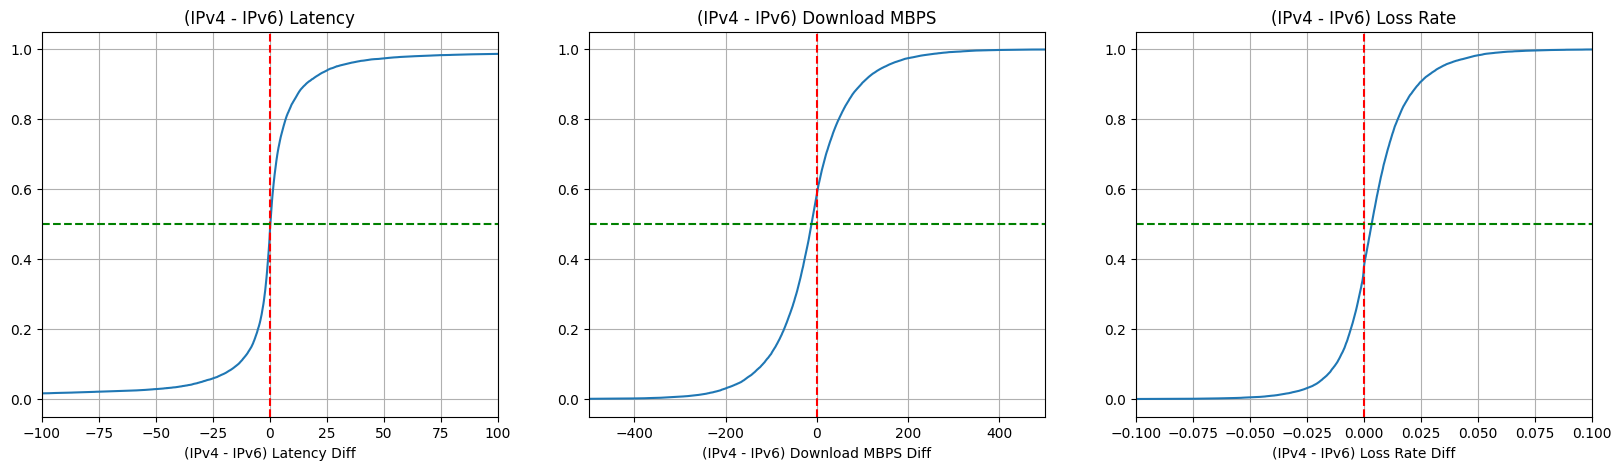

In [20]:
# CDF - Type
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(latency_v4_to_v6, np.arange(0, len(latency_v4_to_v6))/len(latency_v4_to_v6))
axes[0].axvline(0, color='r', linestyle='--')
axes[0].set_title("(IPv4 - IPv6) Latency")
axes[0].set_xlabel("(IPv4 - IPv6) Latency Diff")
axes[0].set_xlim([-100,100])
axes[0].axhline(0.5, color='g', linestyle='--')
#axes[0].set_xscale('symlog')
axes[0].grid()

axes[1].plot(avg_download_mbps_v4_to_v6, np.arange(0, len(avg_download_mbps_v4_to_v6))/len(avg_download_mbps_v4_to_v6))
axes[1].axvline(0, color='r', linestyle='--')
axes[1].set_title("(IPv4 - IPv6) Download MBPS")
axes[1].set_xlabel("(IPv4 - IPv6) Download MBPS Diff")
axes[1].set_xlim([-500, 500])
axes[1].axhline(0.5, color='g', linestyle='--')
#axes[1].set_xscale('symlog')
axes[1].grid()


axes[2].plot(avg_loss_rate_v4_to_v6, np.arange(0, len(avg_loss_rate_v4_to_v6))/len(avg_loss_rate_v4_to_v6))
axes[2].axvline(0, color='r', linestyle='--')
axes[2].set_title("(IPv4 - IPv6) Loss Rate")
axes[2].set_xlabel("(IPv4 - IPv6) Loss Rate Diff")
axes[2].set_xlim([-0.100, 0.100])
axes[2].axhline(0.5, color='g', linestyle='--')
axes[2].grid()


plt.show()

# Step 3: Get Geographic Maps For Average Differences between IPv4 and IPv6 Latency, Download MBPS, and Loss by Country

Note: These maps only look at average differences between IPv4 and IPv6 in regions within countries which have comparible numbers of each (i.e. if a country has IPv4 speed tests in one region and IPv6 speed tests in another, but none of the opposite in either region, those speed tests will not be compared). Looking at country-wide averages (instead of the mean/median of the averages per region) would be a great area for future work.

In [23]:
latency_v4_to_v6_by_country = {}
avg_download_mbps_v4_to_v6_by_country = {}
avg_loss_rate_v4_to_v6_by_country = {}

for x in range(0, len(latency_v4_to_v6_unsorted)):
  if country_codes_unsorted[x] not in latency_v4_to_v6_by_country:
    latency_v4_to_v6_by_country[country_codes_unsorted[x]] = []
    avg_download_mbps_v4_to_v6_by_country[country_codes_unsorted[x]] = []
    avg_loss_rate_v4_to_v6_by_country[country_codes_unsorted[x]] = []

  latency_v4_to_v6_by_country[country_codes_unsorted[x]].append(latency_v4_to_v6_unsorted[x])
  avg_download_mbps_v4_to_v6_by_country[country_codes_unsorted[x]].append(avg_download_mbps_v4_to_v6_unsorted[x])
  avg_loss_rate_v4_to_v6_by_country[country_codes_unsorted[x]].append(avg_loss_rate_v4_to_v6_unsorted[x])

In [51]:
df_medians_means_per_country = pd.DataFrame(columns=["country_code", "latency_median", "mbps_median", "loss_median", "latency_mean", "mbps_mean", "loss_mean"])

for cc in latency_v4_to_v6_by_country:
  df_medians_means_per_country.loc[len(df_medians_means_per_country)] = [cc,
                     np.median(np.array(latency_v4_to_v6_by_country[cc])),
                     np.median(np.array(avg_download_mbps_v4_to_v6_by_country[cc])),
                     np.median(np.array(avg_loss_rate_v4_to_v6_by_country[cc])),
                     np.mean(np.array(latency_v4_to_v6_by_country[cc])),
                     np.mean(np.array(avg_download_mbps_v4_to_v6_by_country[cc])),
                     np.mean(np.array(avg_loss_rate_v4_to_v6_by_country[cc]))]

In [60]:
df_medians_means_per_country

,country_code,latency_median,mbps_median,loss_median,latency_mean,mbps_mean,loss_mean
0,US,0.126455,-12.788754,0.003078,-113.798810,-11.210766,0.003970
1,NL,0.388978,-32.653750,0.003407,1300.970549,-17.192150,0.004889
2,ES,-0.782433,-14.695388,0.001014,338.222175,-4.197567,0.001354
3,DE,0.910253,-9.649064,0.003231,288.889089,-9.190900,0.004964
4,BE,-0.064834,-0.197333,0.002880,180.066618,7.272314,0.003190
...,...,...,...,...,...,...,...
111,UZ,-37.333401,21.834683,0.003120,-37.333401,21.834683,0.003120
112,GE,-5.565240,15.347197,-0.000139,-5.565240,15.347197,-0.000139
113,MN,2.785737,-23.566680,0.005293,2.785737,-23.566680,0.005293
114,MM,-9.480167,-20.032820,0.051965,-9.480167,-20.032820,0.051965


In [61]:
# downloaded from "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
world = world.merge(df_medians_means_per_country, how="left", left_on="ISO_A2", right_on="country_code")

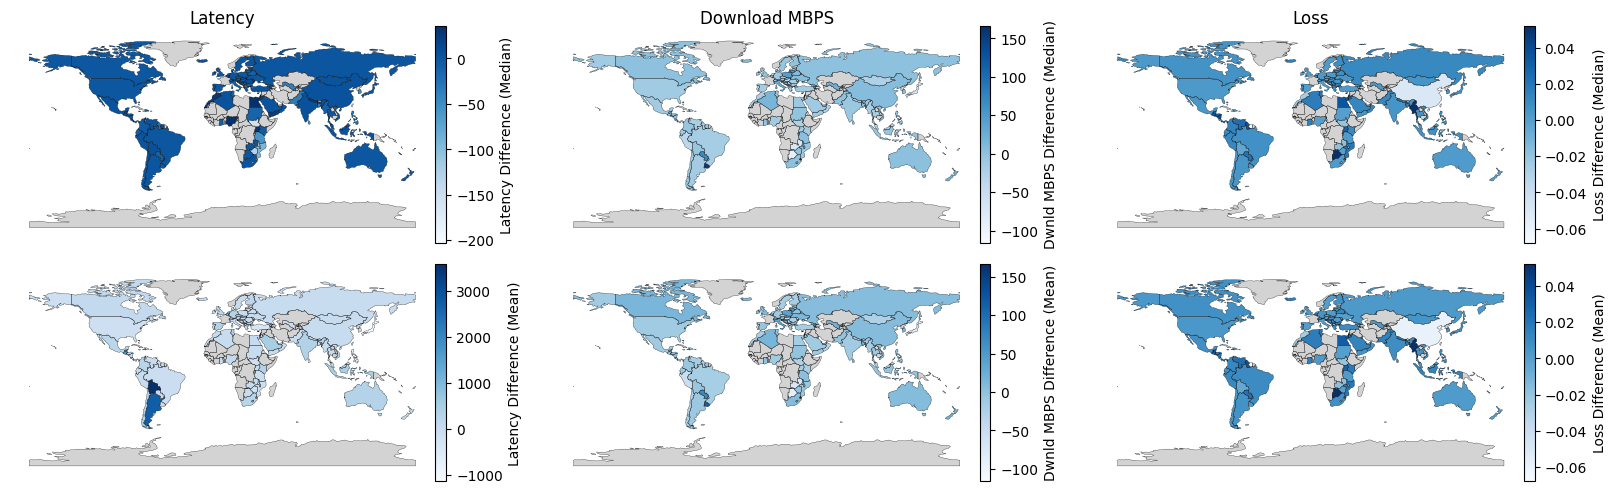

In [78]:
inches_per_pt = 1 / 72.27
fig, axes = plt.subplots(2, 3, figsize=(3*395.8225 * inches_per_pt, 5))

# Median Latency
world.boundary.plot(ax=axes[0][0], color='black', linewidth=0.2)
world.plot(ax=axes[0][0], column='latency_median',
           missing_kwds={ "color": "lightgrey",
           "label": "Missing values",
                        },
        legend_kwds={'pad': 0.001,
                    "label": "Latency Difference (Median)"},
          legend=True,
           cmap='Blues', )

axes[0][0].axis("off")
axes[0][0].set_title("Latency")
axes[0][0].set_ylabel("Median")


# Median MBPS
world.boundary.plot(ax=axes[0][1], color='black', linewidth=0.2)
world.plot(ax=axes[0][1], column='mbps_median',
           missing_kwds={ "color": "lightgrey",
           "label": "Missing values",
                        },
        legend_kwds={'pad': 0.001,
                    "label": "Dwnld MBPS Difference (Median)"},
          legend=True,
           cmap='Blues', )

axes[0][1].axis("off")
axes[0][1].set_title("Download MBPS")


# Median Loss
world.boundary.plot(ax=axes[0][2], color='black', linewidth=0.2)
world.plot(ax=axes[0][2], column='loss_median',
           missing_kwds={ "color": "lightgrey",
           "label": "Missing values",
                        },
        legend_kwds={'pad': 0.001,
                    "label": "Loss Difference (Median)"},
          legend=True,
           cmap='Blues', )

axes[0][2].axis("off")
axes[0][2].set_title("Loss")


# Mean Latency
world.boundary.plot(ax=axes[1][0], color='black', linewidth=0.2)
world.plot(ax=axes[1][0], column='latency_mean',
           missing_kwds={ "color": "lightgrey",
           "label": "Missing values",
                        },
        legend_kwds={'pad': 0.001,
                    "label": "Latency Difference (Mean)"},
          legend=True,
           cmap='Blues', )

axes[1][0].axis("off")

# Mean MBPS
world.boundary.plot(ax=axes[1][1], color='black', linewidth=0.2)
world.plot(ax=axes[1][1], column='mbps_mean',
           missing_kwds={ "color": "lightgrey",
           "label": "Missing values",
                        },
        legend_kwds={'pad': 0.001,
                    "label": "Dwnld MBPS Difference (Mean)"},
          legend=True,
           cmap='Blues', )

axes[1][1].axis("off")

# Mean Loss
world.boundary.plot(ax=axes[1][2], color='black', linewidth=0.2)
world.plot(ax=axes[1][2], column='loss_mean',
           missing_kwds={ "color": "lightgrey",
           "label": "Missing values",
                        },
        legend_kwds={'pad': 0.001,
                    "label": "Loss Difference (Mean)"},
          legend=True,
           cmap='Blues', )

axes[1][2].axis("off")

fig.tight_layout()

# Step 4: Examine IPv4 and IPv6 adoption globally based on the number of speedtests run with each.

In [ ]:
import geopandas as gpd
import matplotlib as mp

In [ ]:
df_ipv6 = mlab_df[mlab_df["client_ip_version"] == 6]
df_ipv4 = mlab_df[mlab_df["client_ip_version"] == 4]

In [ ]:
df_ipv6.apply()

24770

In [ ]:
len(df_ipv4)

24770

In [ ]:
df_ipv6_count = df_ipv6.groupby("client_country")["num_tests"].sum().reset_index()
df_ipv4_count = df_ipv4.groupby("client_country")["num_tests"].sum().reset_index()

In [ ]:
df_ipv4_count

,client_country,num_tests
0,AE,9900
1,AL,109
2,AM,77
3,AR,23438
4,AT,31168
...,...,...
111,VN,19110
112,YE,624
113,ZA,21940
114,ZM,18


In [ ]:
df_merged = pd.merge(df_ipv6_count, df_ipv4_count, on='client_country', suffixes=('_v6', '_v4'))

In [ ]:
df_merged

,client_country,num_tests_v6,num_tests_v4,percentage
0,AE,4597,9900,31.710009
1,AL,91,109,45.5
2,AM,12,77,13.483146
3,AR,25038,23438,51.650301
4,AT,39583,31168,55.946912
...,...,...,...,...
111,VN,17194,19110,47.361172
112,YE,99,624,13.692946
113,ZA,8343,21940,27.550111
114,ZM,16,18,47.058824


In [ ]:
df_merged['percentage'] = (df_merged['num_tests_v6'] / (df_merged['num_tests_v6']+df_merged['num_tests_v4'])) * 100

In [ ]:
df_merged

,client_country,num_tests_v6,num_tests_v4,percentage
0,AE,4597,9900,31.710009
1,AL,91,109,45.5
2,AM,12,77,13.483146
3,AR,25038,23438,51.650301
4,AT,39583,31168,55.946912
...,...,...,...,...
111,VN,17194,19110,47.361172
112,YE,99,624,13.692946
113,ZA,8343,21940,27.550111
114,ZM,16,18,47.058824


In [ ]:
# downloaded from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
world = gpd.read_file('/content/map/ne_110m_admin_0_countries.shp')
world = world.merge(df_merged, how="left", left_on="ISO_A2", right_on="client_country")

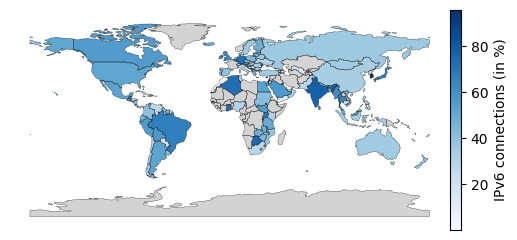

In [ ]:
inches_per_pt = 1 / 72.27
fig = plt.figure(figsize=(395.8225 * inches_per_pt, 2.5)) # ACM CoNEXT template width
ax = fig.add_subplot()
world.boundary.plot(ax=ax, color='black', linewidth=0.2)
world.plot(ax=ax, column='percentage',
           #legend_kwargs={'shrink': 0.3},
           missing_kwds={ "color": "lightgrey",

           #"edgecolor": "red",
           #"hatch": "/////",
           "label": "Missing values",
           #"linewidth": 0.7 ,
                        },
        legend_kwds={'pad': 0.001,
                    "label": "IPv6 connections (in %)"},
          legend=True,
           cmap='Blues', )

ax.axis("off")
fig.tight_layout()
plt.savefig("adoption_world_map.pdf")

In [ ]:
df_merged.sort_values(by="percentage")

,client_country,num_tests_v6,num_tests_v4,percentage
63,MA,13,12235,0.10614
88,RS,1818,20739,8.059582
109,UZ,15,103,12.711864
2,AM,12,77,13.483146
112,YE,99,624,13.692946
...,...,...,...,...
39,GH,40,14,74.074074
15,BW,100,34,74.626866
50,IN,1471823,425179,77.586792
58,KW,225,18,92.592593


# Step 5: Provide a Dynamic Tool for Showing speed test metrics per City/AS/server location.

In [13]:
# If needed (run once per session)
# !pip install plotly ipywidgets --quiet

from google.colab import output
output.enable_custom_widget_manager()

from IPython.display import display
import plotly.graph_objects as go
import ipywidgets as widgets
import numpy as np
import pandas as pd

# --- Make sure array columns are list-like ---
for col in ["latencies_ms", "download_mbps", "loss_rates"]:
    if col in mlab_df.columns:
        mlab_df[col] = mlab_df[col].apply(
            lambda x: list(x) if isinstance(x, (list, tuple, np.ndarray)) else ([] if pd.isna(x) else [x])
        )

# --- Dropdowns ---
city_dropdown = widgets.Dropdown(
    options=sorted(mlab_df["client_city"].dropna().unique()),
    description="City:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='350px')
)

asn_dropdown = widgets.Dropdown(
    options=[],
    description="ASN:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='350px')
)

site_dropdown = widgets.Dropdown(
    options=[],
    description="Server Site:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='350px')
)

# --- Metric toggle buttons (the new "button for the metric") ---
metric_options = [
    ("Latency (ms)", "latencies_ms"),
    ("Download (Mbps)", "download_mbps"),
    ("Loss Rate", "loss_rates"),
]
metric_toggle = widgets.ToggleButtons(
    options=metric_options,
    value="latencies_ms",
    description="Metric:",
    style={'description_width': 'initial'}
)
label_by_value = {val: label for (label, val) in metric_options}

# Plot trigger button
plot_button = widgets.Button(
    description="Plot",
    button_style='',
    layout=widgets.Layout(width='120px')
)

# Output area
out = widgets.Output()

# --- Dependent dropdown updates ---
def update_asn_options(*_):
    city = city_dropdown.value
    filtered = mlab_df[mlab_df["client_city"] == city] if city else mlab_df.iloc[0:0]
    asns = sorted(filtered["client_asn"].dropna().unique())
    asn_dropdown.options = asns
    if asns:
        asn_dropdown.value = asns[0]

def update_site_options(*_):
    city = city_dropdown.value
    asn = asn_dropdown.value
    filtered = mlab_df[(mlab_df["client_city"] == city) & (mlab_df["client_asn"] == asn)] if (city is not None and asn is not None) else mlab_df.iloc[0:0]
    sites = sorted(filtered["server_site"].dropna().unique())
    site_dropdown.options = sites
    if sites:
        site_dropdown.value = sites[0]

city_dropdown.observe(update_asn_options, names='value')
asn_dropdown.observe(update_site_options, names='value')

# Initialize
if len(city_dropdown.options) > 0 and city_dropdown.value is None:
    city_dropdown.value = city_dropdown.options[0]
else:
    update_asn_options()
update_site_options()

# --- Plot function (single metric) ---
def plot_metrics(city, asn, site, metric_value):
    filtered = mlab_df[
        (mlab_df["client_city"] == city)
        & (mlab_df["client_asn"] == asn)
        & (mlab_df["server_site"] == site)
    ]
    with out:
        out.clear_output(wait=True)
        if filtered.empty:
            print("No data available for this selection.")
            return

        metric_label = label_by_value[metric_value]

        fig = go.Figure()
        for version, label in [(4, "IPv4"), (6, "IPv6")]:
            row = filtered[filtered["client_ip_version"] == version]
            if not row.empty:
                ydata = row[metric_value].iloc[0]
                ydata = [v for v in ydata if v is not None and pd.notna(v)]
                if len(ydata) > 0:
                    fig.add_trace(go.Box(
                        y=ydata,
                        name=label,
                        boxmean='sd'
                    ))

        fig.update_layout(
            title=f"{metric_label} — {city} / ASN {asn} / Site {site}",
            yaxis_title=metric_label,
            boxmode="group",
            template="plotly_white",
            height=420
        )
        display(fig)

# Button callback
def on_plot_button_clicked(_):
    plot_metrics(city_dropdown.value, asn_dropdown.value, site_dropdown.value, metric_toggle.value)

plot_button.on_click(on_plot_button_clicked)

# Also re-plot when metric changes (optional live update)
def on_metric_change(change):
    if change["name"] == "value" and city_dropdown.value and asn_dropdown.value and site_dropdown.value:
        plot_metrics(city_dropdown.value, asn_dropdown.value, site_dropdown.value, change["new"])

metric_toggle.observe(on_metric_change, names='value')

# --- UI ---
controls = widgets.HBox([metric_toggle, plot_button])
ui = widgets.VBox([city_dropdown, asn_dropdown, site_dropdown, controls])
display(ui, out)

# Auto-plot once
if city_dropdown.value and asn_dropdown.value and site_dropdown.value:
    plot_metrics(city_dropdown.value, asn_dropdown.value, site_dropdown.value, metric_toggle.value)

Output()